In [10]:
from crystalbuilder import *
import crystalbuilder.geometry as geo
import matplotlib.pyplot as plt
import tidy3d as td
import crystalbuilder.convert as cv
import numpy as np
import vedo

In [2]:
a1 = [1, 0, 0]
a2 = [0, 1 ,0]
a3 = [0, 0, 1]

a_mag = .5
geo_lattice = lattice.Lattice(a1, a2, a3, magnitude = [a_mag, a_mag, a_mag])

In [4]:
diamond = bilbao.SpaceGroup(227)
pt = 1/8
points = diamond.calculate_points(point_list=[(pt, pt, pt)]) #This is the 8a wyckoff position

In [5]:
radius = .05
connection_sites = geo.NearestNeighbors(points, radius=radius, neighborhood_range=.45, a_mag = a_mag)
geometry=connection_sites

In [6]:
a1_reps = 8
a2_reps = 8
a3_reps = 4
crystal = geo_lattice.tile_geogeometry(geometry, a1_reps, a2_reps, a3_reps )
# crystal = geometry

In [7]:
scene = viewer.visualize(crystal)
scene.show().close()



In [8]:
newgeo = cv.geo_to_tidy3d(crystal, 2.5)

In [9]:
# create source
lda0 = 0.75  # wavelength of interest (length scales are micrometers in Tidy3D)
freq0 = td.C_0 / lda0  # frequency of interest

source = td.PointDipole(
    center=(0, 0, 0),  # position of the dipole
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10.0),  # time profile of the source
    polarization="Ey",  # polarization of the dipole
) # type: ignore



sim = td.Simulation(
    size=(15, 15, 8),  # simulation domain size
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20
    ),  # automatic nonuniform FDTD grid with 25 grids per wavelength in the material
    structures=[newgeo],
    sources=[source],
    run_time=3e-13,  # physical simulation time in second
) # type: ignore
sim.plot_3d()





In [ ]:
from tidy3d import web

task_id = web.upload(sim, task_name="8x8x3-DiamondPhC")
# Load the data through task-id
sim_data = web.load('fdve-fdebf748-8be8-4117-bc2c-7b11cecdecca')




<xarray.Dataset> Size: 1kB
Dimensions:    (freq: 24)
Coordinates:
  * freq       (freq) float64 192B -6.289e+14 -3.981e+14 ... 1.044e+15 1.254e+15
Data variables:
    decay      (freq) float64 192B 3.489e+13 3.495e+13 ... 8.525e+13 -1.956e+15
    Q          (freq) float64 192B 56.64 35.78 -2.139 ... 357.8 38.46 -2.014
    amplitude  (freq) float64 192B 6.758 6.867 30.53 ... 0.1203 2.438 97.21
    phase      (freq) float64 192B -2.857 -2.925 -2.4 ... 1.628 -0.7486 0.06056
    error      (freq) float64 192B 0.1849 0.1496 3.696 ... 0.2023 0.2311 8.036


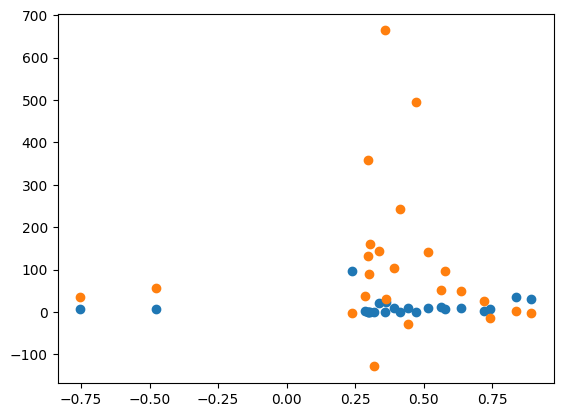

In [16]:
from tidy3d.plugins.resonance import ResonanceFinder

field = sim_data.load_field_monitor('fieldtimemonitor_2')

resfind = ResonanceFinder(freq_window=[5e13,1e15]).run(field)
print(resfind)
plt.scatter(td.C_0/resfind.freq, resfind.amplitude)
plt.scatter(td.C_0/resfind.freq, resfind.Q)